In [1]:
import os
import torch
import pickle
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

In [3]:
import pickle
from datasets import Dataset, DatasetDict, ClassLabel

# 1. Load your Exercise 5 data
with open("movies_dataset.pkl", "rb") as f:
    movies = pickle.load(f)

# 2. Fix the error by casting the label column to ClassLabel
raw_ds = Dataset.from_dict({"text": movies.data, "label": movies.target})
raw_ds = raw_ds.cast_column("label", ClassLabel(num_classes=2)) # <--- THIS IS THE FIX

# 3. Stratified split (70% Train, 15% Dev, 15% Test)
train_testvalid = raw_ds.train_test_split(test_size=0.3, stratify_by_column="label", seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)

dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
model_checkpoint = "bert-base-uncased" # Specified BERT model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    # Truncate at BERT's max length of 512
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_movies = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics from Lab 6
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1": f1}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\FORMAT LAP HP\jim\CS\NLP\exercises\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\KYRIAKOS\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [7]:
from transformers import pipeline
mask_pipe = pipeline("fill-mask", model="bert-base-uncased", device=0 if device=="cuda" else -1)
# Use [MASK] instead of <mask> for BERT
print(mask_pipe("This movie was a [MASK] success!"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[{'score': 0.5399720668792725, 'token': 4121, 'token_str': 'huge', 'sequence': 'this movie was a huge success!'}, {'score': 0.15167471766471863, 'token': 2307, 'token_str': 'great', 'sequence': 'this movie was a great success!'}, {'score': 0.13770081102848053, 'token': 2502, 'token_str': 'big', 'sequence': 'this movie was a big success!'}, {'score': 0.03892922401428223, 'token': 14388, 'token_str': 'tremendous', 'sequence': 'this movie was a tremendous success!'}, {'score': 0.016732731834053993, 'token': 3293, 'token_str': 'commercial', 'sequence': 'this movie was a commercial success!'}]


In [9]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# Tune Hyper-parameter: Task-specific layer size
config = AutoConfig.from_pretrained(model_checkpoint, num_labels=2)
config.classifier_dropout = 0.2 # Tuning dropout as an example
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)

training_args = TrainingArguments(
    output_dir='./bert_full_tuned/',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\KYRIAKOS\AppData\Local\Temp\ipykernel_8748\1793740469.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.425531,0.816667,0.813515
2,No log,0.291339,0.883333,0.883114
3,0.403800,0.513377,0.880000,0.879464
4,0.403800,0.502118,0.903333,0.902944
5,0.403800,0.485652,0.910000,0.909831


TrainOutput(global_step=875, training_loss=0.2647717524937221, metrics={'train_runtime': 465.1136, 'train_samples_per_second': 15.05, 'train_steps_per_second': 1.881, 'total_flos': 1841777387520000.0, 'train_loss': 0.2647717524937221, 'epoch': 5.0})

In [11]:
model_frozen = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Tune Hyper-parameter: Freeze specific number of blocks
# BERT-base has 12 layers. Let's freeze the first 6.
num_layers_to_freeze = 6
for layer in model_frozen.bert.encoder.layer[:num_layers_to_freeze]:
    for param in layer.parameters():
        param.requires_grad = False

training_args.output_dir = './bert_partial_frozen/'
trainer_frozen = Trainer(
    model=model_frozen,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer_frozen.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\KYRIAKOS\AppData\Local\Temp\ipykernel_8748\908355501.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_frozen = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.361561,0.843333,0.842054
2,No log,0.319177,0.880000,0.879658
3,0.374400,0.437234,0.883333,0.883270
4,0.374400,0.458260,0.900000,0.899929
5,0.374400,0.476104,0.890000,0.889901


TrainOutput(global_step=875, training_loss=0.264391610281808, metrics={'train_runtime': 405.0081, 'train_samples_per_second': 17.284, 'train_steps_per_second': 2.16, 'total_flos': 1841777387520000.0, 'train_loss': 0.264391610281808, 'epoch': 5.0})

In [13]:
from peft import LoraConfig, get_peft_model, TaskType

model_lora = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1,
    target_modules=["query", "value"] # Standard BERT target modules
)

model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()

training_args.output_dir = './bert_lora/'
trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer_lora.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\KYRIAKOS\AppData\Local\Temp\ipykernel_8748\535007171.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.690042,0.560000,0.551204
2,No log,0.686457,0.570000,0.568615
3,0.686500,0.682773,0.586667,0.585173
4,0.686500,0.680366,0.553333,0.548822
5,0.686500,0.679055,0.556667,0.552485


TrainOutput(global_step=875, training_loss=0.6806913888113839, metrics={'train_runtime': 355.0894, 'train_samples_per_second': 19.713, 'train_steps_per_second': 2.464, 'total_flos': 1848152248320000.0, 'train_loss': 0.6806913888113839, 'epoch': 5.0})

In [14]:
# Token Embeddings
from transformers import AutoModel
base_model = AutoModel.from_pretrained(model_checkpoint).to(device)
sample_text = movies.data[0]
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True).to(device)
with torch.no_grad():
    embeddings = base_model(**inputs).last_hidden_state
print(f"Token embedding shape: {embeddings.shape}")

# Sentence Similarity
from sentence_transformers import SentenceTransformer
s_model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = [movies.data[0], movies.data[1]]
encoded = s_model.encode(sentences)
similarity = encoded[0] @ encoded[1]
print(f"Cosine similarity between reviews: {similarity:.4f}")

Token embedding shape: torch.Size([1, 512, 768])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\FORMAT LAP HP\jim\CS\NLP\exercises\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\KYRIAKOS\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine similarity between reviews: 0.4704


In [16]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import pandas as pd

def generate_report_table(trainers_dict, tokenized_ds, split_name):
    rows = []
    for name, trainer in trainers_dict.items():
        # Get predictions
        output = trainer.predict(tokenized_ds[split_name])
        labels = output.label_ids
        probs = torch.nn.functional.softmax(torch.tensor(output.predictions), dim=-1).numpy()
        preds = np.argmax(output.predictions, axis=1)

        # Metrics: Per-class (0=Neg, 1=Pos)
        p, r, f, _ = precision_recall_fscore_support(labels, preds, average=None)
        # PR-AUC per class
        pr_neg = average_precision_score(np.where(labels==0, 1, 0), probs[:, 0])
        pr_pos = average_precision_score(np.where(labels==1, 1, 0), probs[:, 1])
        
        # Macro Metrics
        mp, mr, mf, _ = precision_recall_fscore_support(labels, preds, average='macro')
        mpr = (pr_neg + pr_pos) / 2

        rows.append({
            "Model": name,
            "Neg_P": p[0], "Neg_R": r[0], "Neg_F1": f[0], "Neg_PRAUC": pr_neg,
            "Pos_P": p[1], "Pos_R": r[1], "Pos_F1": f[1], "Pos_PRAUC": pr_pos,
            "Macro_P": mp, "Macro_R": mr, "Macro_F1": mf, "Macro_PRAUC": mpr
        })
    
    return pd.DataFrame(rows).round(4)

# List of your trained models
trainers = {
    "BERT-Tuned": trainer, 
    "BERT-Frozen": trainer_frozen, 
    "BERT-LoRA": trainer_lora
}

for split in ["train", "validation", "test"]:
    print(f"\n--- RESULTS TABLE: {split.upper()} SUBSET ---")
    display(generate_report_table(trainers, tokenized_movies, split))


--- RESULTS TABLE: TRAIN SUBSET ---


,Model,Neg_P,Neg_R,Neg_F1,Neg_PRAUC,Pos_P,Pos_R,Pos_F1,Pos_PRAUC,Macro_P,Macro_R,Macro_F1,Macro_PRAUC
0,BERT-Tuned,0.9971,0.9971,0.9971,0.9997,0.9971,0.9971,0.9971,0.9997,0.9971,0.9971,0.9971,0.9997
1,BERT-Frozen,0.9899,0.9829,0.9864,0.9973,0.9830,0.9900,0.9865,0.9972,0.9865,0.9864,0.9864,0.9973
2,BERT-LoRA,0.6051,0.5714,0.5878,0.6278,0.5940,0.6271,0.6101,0.6277,0.5996,0.5993,0.5990,0.6278



--- RESULTS TABLE: VALIDATION SUBSET ---


,Model,Neg_P,Neg_R,Neg_F1,Neg_PRAUC,Pos_P,Pos_R,Pos_F1,Pos_PRAUC,Macro_P,Macro_R,Macro_F1,Macro_PRAUC
0,BERT-Tuned,0.9489,0.8667,0.9059,0.9688,0.8773,0.9533,0.9137,0.9529,0.9131,0.9100,0.9098,0.9609
1,BERT-Frozen,0.9225,0.8733,0.8973,0.9703,0.8797,0.9267,0.9026,0.9621,0.9011,0.9000,0.8999,0.9662
2,BERT-LoRA,0.5985,0.5267,0.5603,0.5741,0.5774,0.6467,0.6101,0.5809,0.5879,0.5867,0.5852,0.5775



--- RESULTS TABLE: TEST SUBSET ---


,Model,Neg_P,Neg_R,Neg_F1,Neg_PRAUC,Pos_P,Pos_R,Pos_F1,Pos_PRAUC,Macro_P,Macro_R,Macro_F1,Macro_PRAUC
0,BERT-Tuned,0.9098,0.8067,0.8551,0.9369,0.8263,0.92,0.8707,0.8902,0.8681,0.8633,0.8629,0.9135
1,BERT-Frozen,0.9084,0.7933,0.8470,0.9213,0.8166,0.92,0.8652,0.8926,0.8625,0.8567,0.8561,0.9070
2,BERT-LoRA,0.5556,0.5000,0.5263,0.5520,0.5455,0.60,0.5714,0.5508,0.5505,0.5500,0.5489,0.5514


Generating learning curves for BERT-Tuned...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.463125,0.913333,0.913194
2,No log,0.536737,0.896667,0.896610
3,No log,0.476685,0.913333,0.913272
4,No log,0.481822,0.913333,0.913272
5,No log,0.495003,0.906667,0.906650


Size 10% - Train F1: 1.0000, Val F1: 0.9132


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.537250,0.906667,0.906563
2,No log,0.564785,0.900000,0.899960
3,No log,0.581715,0.903333,0.903306
4,No log,0.586972,0.903333,0.903306
5,No log,0.590642,0.903333,0.903306


Size 30% - Train F1: 1.0000, Val F1: 0.9066


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.808880,0.856667,0.854911
2,No log,0.923857,0.866667,0.865320
3,No log,0.723337,0.896667,0.896528
4,No log,0.825793,0.883333,0.882759
5,No log,0.792005,0.890000,0.889557


Size 50% - Train F1: 1.0000, Val F1: 0.8965


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.225050,0.823333,0.818076
2,No log,0.690507,0.893333,0.893215
3,No log,0.739758,0.896667,0.896528
4,No log,0.682628,0.910000,0.909991
5,0.035400,0.690420,0.906667,0.906650


Size 70% - Train F1: 1.0000, Val F1: 0.9100


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.072510,0.840000,0.837391
2,No log,0.627002,0.886667,0.886541
3,0.081300,0.690270,0.886667,0.886586
4,0.081300,0.699566,0.893333,0.893162
5,0.081300,0.685243,0.906667,0.906463


Size 100% - Train F1: 1.0000, Val F1: 0.9065


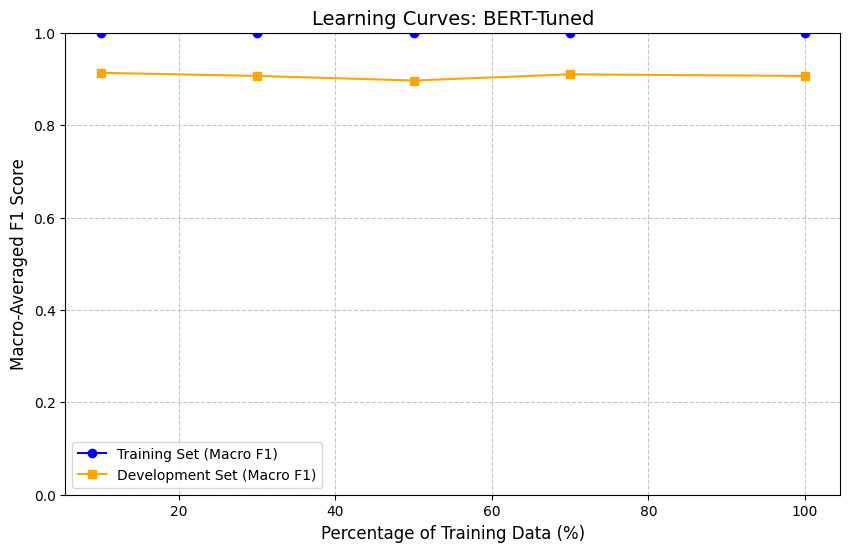

In [17]:
import matplotlib.pyplot as plt

def plot_learning_curves(trainer, tokenized_train, tokenized_val, model_name="BERT-Tuned"):
    train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
    train_f1s = []
    val_f1s = []

    print(f"Generating learning curves for {model_name}...")
    
    # Save original training dataset to restore later
    original_train_ds = trainer.train_dataset

    for size in train_sizes:
        # Create subset
        num_samples = int(len(tokenized_train) * size)
        subset = tokenized_train.select(range(num_samples))
        
        # Update trainer and train briefly on the subset
        trainer.train_dataset = subset
        trainer.train()
        
        # Evaluate on the subset and the full validation set
        train_metrics = trainer.evaluate(subset)
        val_metrics = trainer.evaluate(tokenized_val)
        
        train_f1s.append(train_metrics['eval_f1'])
        val_f1s.append(val_metrics['eval_f1'])
        print(f"Size {int(size*100)}% - Train F1: {train_metrics['eval_f1']:.4f}, Val F1: {val_metrics['eval_f1']:.4f}")

    # Restore original dataset
    trainer.train_dataset = original_train_ds

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot([s * 100 for s in train_sizes], train_f1s, 'o-', label='Training Set (Macro F1)', color='blue')
    plt.plot([s * 100 for s in train_sizes], val_f1s, 's-', label='Development Set (Macro F1)', color='orange')
    
    plt.title(f'Learning Curves: {model_name}', fontsize=14)
    plt.xlabel('Percentage of Training Data (%)', fontsize=12)
    plt.ylabel('Macro-Averaged F1 Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.ylim(0, 1.0) # Standard scale for F1
    plt.show()

# Run the visualization for your primary tuned model
plot_learning_curves(trainer, tokenized_movies['train'], tokenized_movies['validation'])

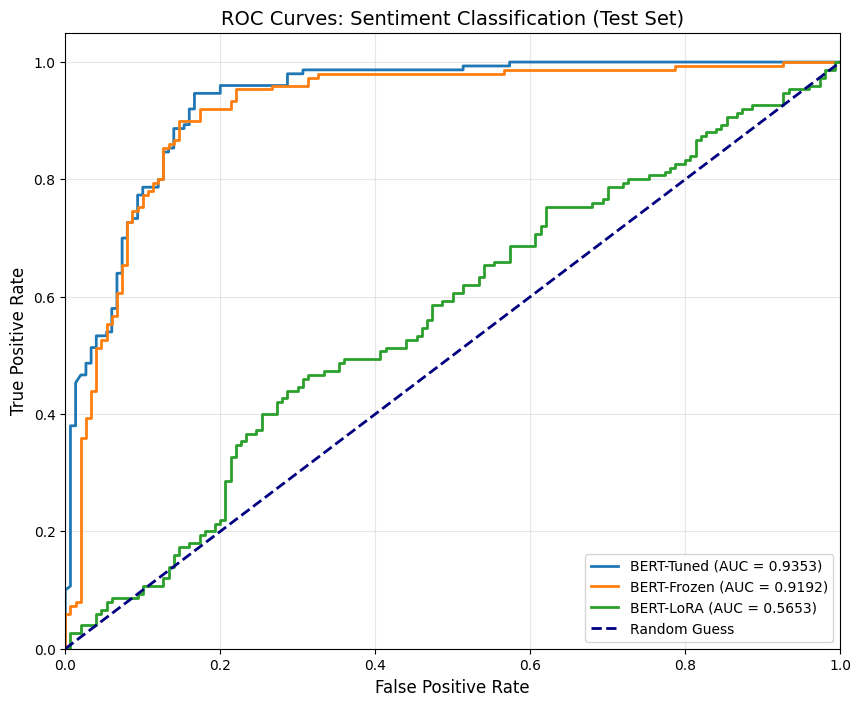

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(trainers_dict, tokenized_ds, split='test'):
    plt.figure(figsize=(10, 8))
    
    for name, trainer in trainers_dict.items():
        # Get raw predictions (logits)
        output = trainer.predict(tokenized_ds[split])
        labels = output.label_ids
        # Convert logits to probabilities for the positive class (index 1)
        probs = torch.nn.functional.softmax(torch.tensor(output.predictions), dim=-1)[:, 1].numpy()
        
        # Calculate ROC data
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves: Sentiment Classification ({split.capitalize()} Set)', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Define the dictionary of your trainers if not already defined
trainers = {
    "BERT-Tuned": trainer, 
    "BERT-Frozen": trainer_frozen, 
    "BERT-LoRA": trainer_lora
}

plot_roc_curves(trainers, tokenized_movies)

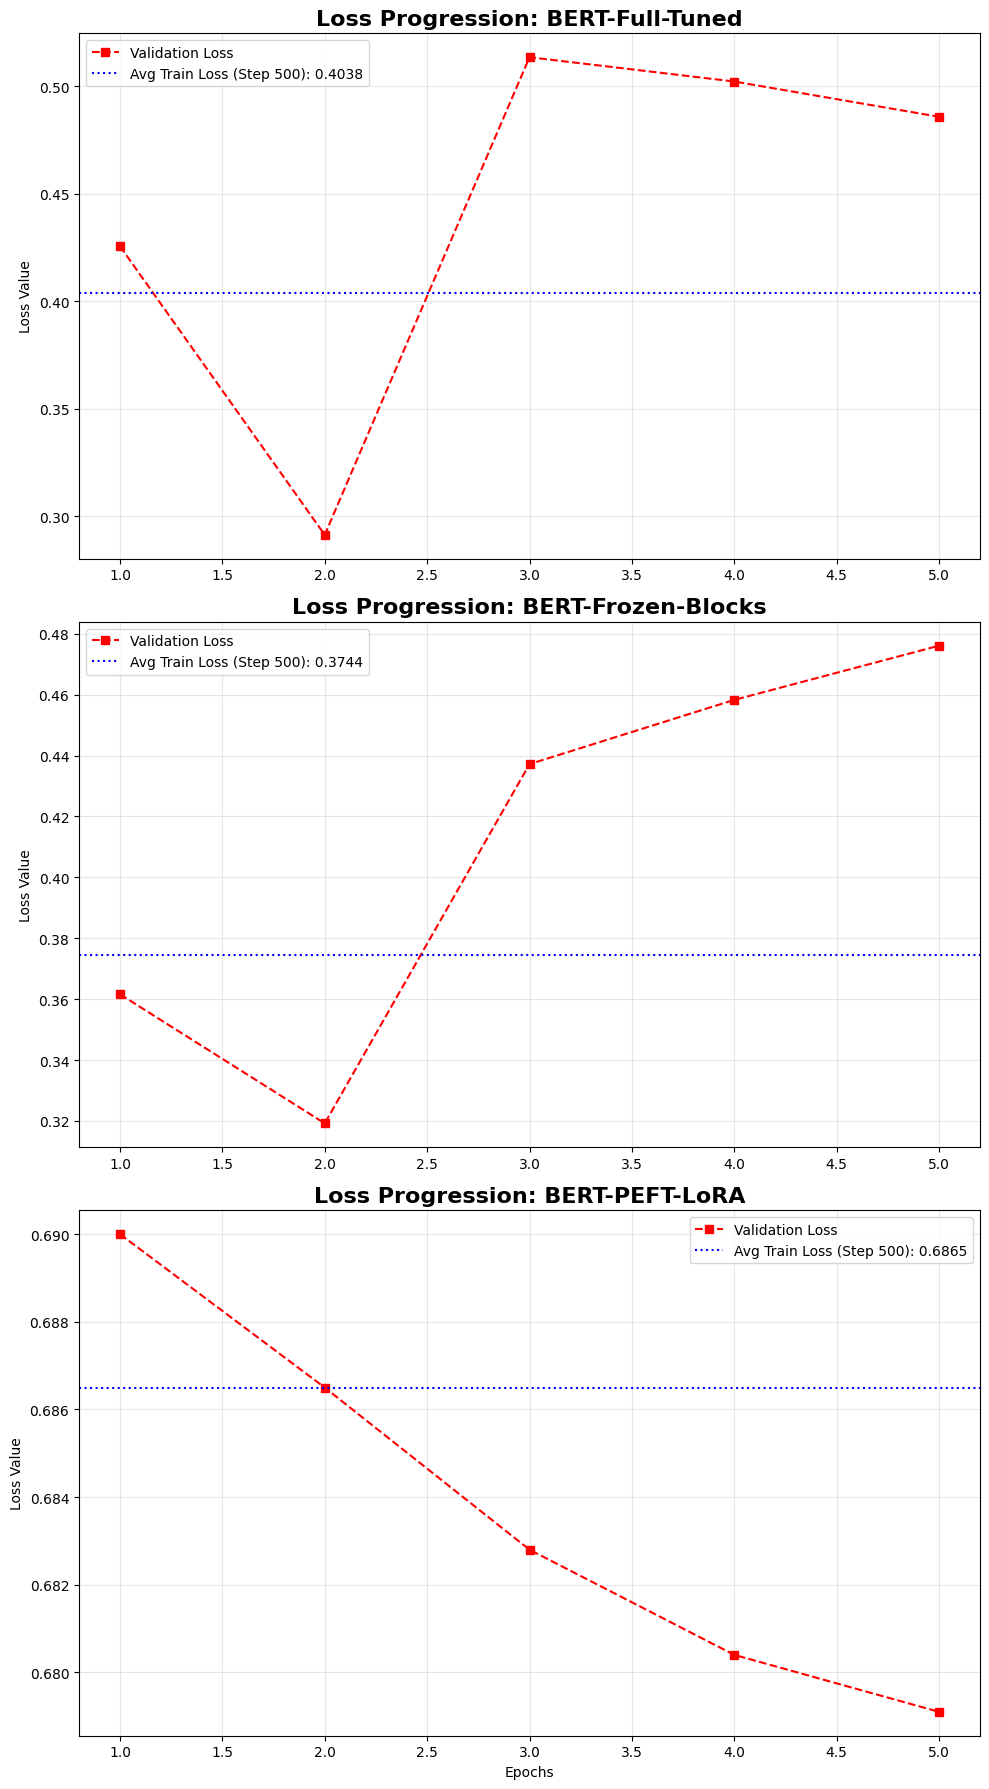

In [21]:
import matplotlib.pyplot as plt

# 1. Hardcoded data extracted from your notebook training tables
# Format: [Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5]

# BERT-Full-Tuned (Cell 4)
tuned_val_loss = [0.4255, 0.2913, 0.5134, 0.5021, 0.4857]
# Training loss logged at step 500 (approx. Epoch 2.85)
tuned_train_loss_val = 0.4038 

# BERT-Frozen-Blocks (Cell 5)
frozen_val_loss = [0.3616, 0.3192, 0.4372, 0.4583, 0.4761]
# Training loss logged at step 500
frozen_train_loss_val = 0.3744 

# BERT-PEFT-LoRA (Cell 6)
lora_val_loss = [0.6900, 0.6865, 0.6828, 0.6804, 0.6791]
# Training loss logged at step 500
lora_train_loss_val = 0.6865 

epochs = [1, 2, 3, 4, 5]

# 2. Plotting the three charts separately
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Chart 1: BERT-Full-Tuned
axes[0].plot(epochs, tuned_val_loss, label='Validation Loss', marker='s', color='red', linestyle='--')
axes[0].axhline(y=tuned_train_loss_val, color='blue', linestyle=':', label=f'Avg Train Loss (Step 500): {tuned_train_loss_val}')
axes[0].set_title('Loss Progression: BERT-Full-Tuned', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Loss Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Chart 2: BERT-Frozen-Blocks
axes[1].plot(epochs, frozen_val_loss, label='Validation Loss', marker='s', color='red', linestyle='--')
axes[1].axhline(y=frozen_train_loss_val, color='blue', linestyle=':', label=f'Avg Train Loss (Step 500): {frozen_train_loss_val}')
axes[1].set_title('Loss Progression: BERT-Frozen-Blocks', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Loss Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Chart 3: BERT-PEFT-LoRA
axes[2].plot(epochs, lora_val_loss, label='Validation Loss', marker='s', color='red', linestyle='--')
axes[2].axhline(y=lora_train_loss_val, color='blue', linestyle=':', label=f'Avg Train Loss (Step 500): {lora_train_loss_val}')
axes[2].set_title('Loss Progression: BERT-PEFT-LoRA', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss Value')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()